## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
import sklearn.model_selection as skl
from random import sample
from sklearn.metrics import roc_curve, auc
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import precision_recall_curve, f1_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
94993,00024712_000.png,No Finding,0,24712,23,F,PA,2462,2615,0.143,0.143,NaN,/data/images_010/images/00024712_000.png
65537,00016184_010.png,No Finding,10,16184,43,F,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00016184_010.png
22139,00005867_000.png,No Finding,0,5867,20,M,AP,2500,2048,0.171,0.171,NaN,/data/images_003/images/00005867_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
31499,00008232_002.png,Effusion|Infiltration,2,8232,41,M,AP,2500,2048,0.168,...,0,0,0,1,0,0,0,0,0,0
52146,00013158_001.png,Mass,1,13158,38,M,PA,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0
10081,00002614_003.png,Emphysema,3,2614,68,M,PA,2446,2689,0.143,...,1,0,0,0,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].astype(str)

## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    # Condition 1 - To have EQUAL amount of positive and negative cases of Pneumonia in Training
    p_inds = train_df[train_df.pneumonia_class=='1'].index.tolist()
    np_inds = train_df[train_df.pneumonia_class=='0'].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    return train_df, valid_df

train_data, val_data = create_splits([])

In [7]:
(len(train_data), len(val_data), val_data['Pneumonia'].sum())

(2290, 22424, 286)

In [6]:
train_data['Pneumonia'].sum()/len(train_data)

0.5

In [7]:
val_data['Pneumonia'].sum()/len(val_data)

0.012754191937210132

In [8]:
all_xray_df['Pneumonia'].sum()/len(all_xray_df)

0.012763110952550838

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
def my_image_augmentation(rescale=None,
                         horizontal_flip=False,
                         vertical_flip=False,
                         height_shift_range=0.0,
                         width_shift_range=0.0,
                         rotation_range=0,
                         shear_range=0.0,
                         zoom_range=0.0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=rescale,
                              horizontal_flip = horizontal_flip, 
                              vertical_flip = vertical_flip, 
                              height_shift_range= height_shift_range, 
                              width_shift_range=width_shift_range, 
                              rotation_range=rotation_range, 
                              shear_range = shear_range,
                              zoom_range=zoom_range)
    return my_idg


def make_train_gen():
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    # Todo
    
    my_train_idg = my_image_augmentation(rescale=1. / 255.0,
                                          horizontal_flip = True, 
                                          vertical_flip = False, 
                                          height_shift_range= 0.1, 
                                          width_shift_range=0.1, 
                                          rotation_range=20, 
                                          shear_range = 0.1,
                                          zoom_range=0.1)
    
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = BATCH_SIZE
                                         )
     
    return train_gen


def make_val_gen():
    my_val_idg = my_image_augmentation(rescale=1. / 255.0)
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = BATCH_SIZE) 
    
    # Todo
    return val_gen

train_gen = make_train_gen()
val_gen = make_val_gen()

Found 2290 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

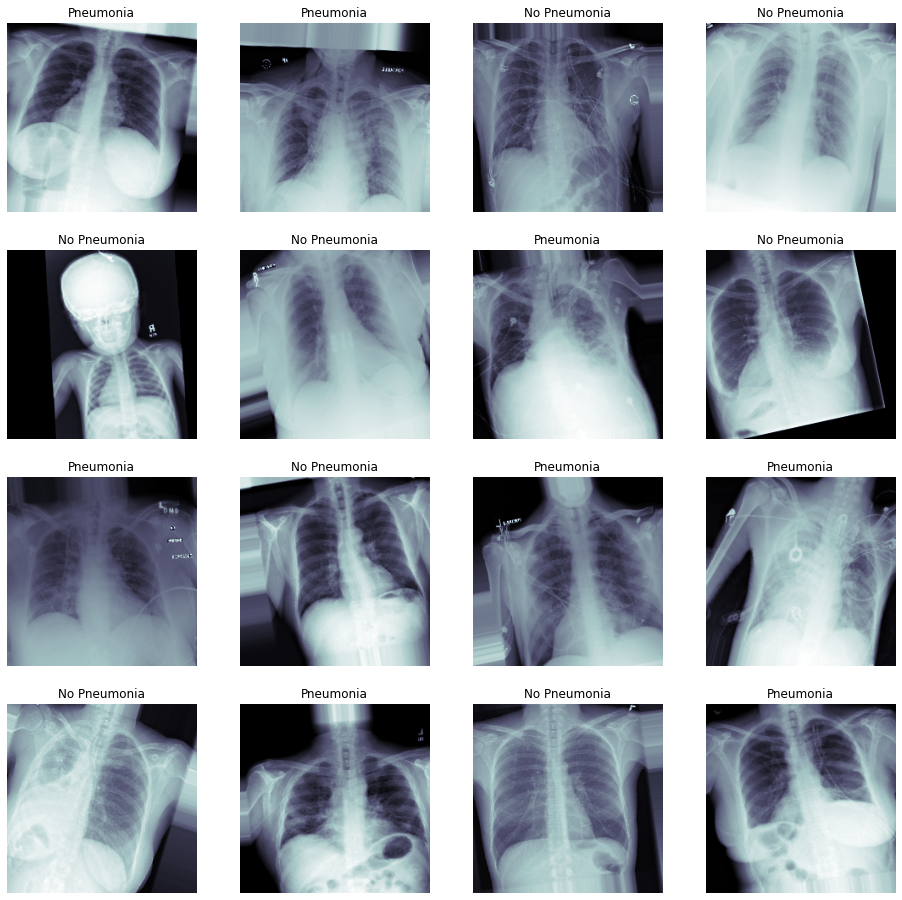

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [10]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    vgg_model = load_pretrained_model()
    for layer in vgg_model.layers[0:15]:
        layer.trainable = False
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = [tf.keras.metrics.AUC(), 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]
    
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

my_model = build_my_model()
my_model.save('my_model_vgg16_model.h5')

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

553467904/553467096 [==============================] - 3s 0us/step


In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

MONITOR = 'val_loss'
MODE = 'min'

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= MONITOR, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= MODE, 
                             save_weights_only = True)

early = EarlyStopping(monitor= MONITOR, 
                      mode= MODE, 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [16]:
## train your model
# Todo

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 40, 
                          callbacks = callbacks_list)

553467904/553467096 [==============================] - 3s 0us/step
Epoch 1/40
144/144 [==============================] - 61s 425ms/step - loss: 0.7269 - auc_1: 0.4733 - precision_1: 0.4729 - recall_1: 0.5105 - val_loss: 0.6504 - val_auc_1: 0.4905 - val_precision_1: 0.4930 - val_recall_1: 0.5214

Epoch 00001: val_loss improved from inf to 0.65038, saving model to xray_class_my_model.best.hdf5
Epoch 2/40
144/144 [==============================] - 58s 402ms/step - loss: 0.6911 - auc_1: 0.5058 - precision_1: 0.5072 - recall_1: 0.5346 - val_loss: 0.6760 - val_auc_1: 0.5159 - val_precision_1: 0.5127 - val_recall_1: 0.5463

Epoch 00002: val_loss did not improve from 0.65038
Epoch 3/40
144/144 [==============================] - 60s 414ms/step - loss: 0.6924 - auc_1: 0.5177 - precision_1: 0.5139 - recall_1: 0.4919 - val_loss: 0.6734 - val_auc_1: 0.5173 - val_precision_1: 0.5135 - val_recall_1: 0.4253

Epoch 00003: val_loss did not improve from 0.65038
Epoch 4/40
144/144 [=======================

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [12]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

16/16 [==============================] - 6s 345ms/step


In [12]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    # Ensure that p_y are probabilities, not binary labels
    fpr, tpr, _ = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["auc_1"], label="train_auc")
    plt.plot(np.arange(0, N), history.history["val_auc_1"], label="val_auc")
    plt.plot(np.arange(0, N), history.history["precision_1"], label="train_precision")
    plt.plot(np.arange(0, N), history.history["val_precision_1"], label="val_precision")
    plt.plot(np.arange(0, N), history.history["recall_1"], label="train_recall")
    plt.plot(np.arange(0, N), history.history["val_recall_1"], label="val_recall")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

In [29]:
len(pred_Y)

16

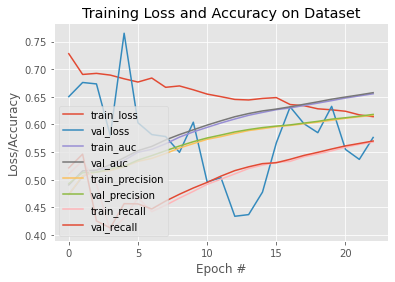

In [30]:
## plot figures

# Todo
plot_history(history)

In [13]:
all_valX = []
all_valY = []

# Get the number of steps to go through the entire validation data
#num_steps = len(val_gen)
num_steps = 200

# Loop over all batches and collect the data
for i in range(num_steps):
    valX_batch, valY_batch = val_gen.next()  # Get the next batch
    all_valX.append(valX_batch)  # Add the batch data to the list
    all_valY.append(valY_batch)

# Convert the list of arrays into single arrays
all_valX = np.concatenate(all_valX)
all_valY = np.concatenate(all_valY)
pred_all_valY = my_model.predict(all_valX, batch_size = 32, verbose = True)


3200/3200 [==============================] - 17s 5ms/step


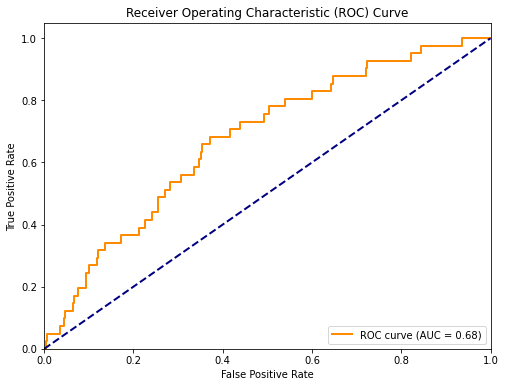

In [14]:
plot_auc(all_valY, pred_all_valY)

In [10]:
def build_resnet50_model():
    # Load ResNet50 with pre-trained ImageNet weights, exclude the top classification layer.
    model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # Freeze the first layers of ResNet50 (optional depending on the task)
    for layer in model.layers[:170]:
        layer.trainable = False
    for layer in model.layers[170:]:
        layer.trainable = True

    # Create a new Sequential model
    new_model = Sequential()

    # Add the convolutional part of the ResNet50 model.
    new_model.add(model)

    # Flatten the output of the ResNet50 model because it is from a convolutional layer.
    new_model.add(Flatten())

    # Add a dropout-layer to prevent overfitting.
    new_model.add(Dropout(0.5))

    # Add dense layers for combining features.
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))
    new_model.add(Dense(256, activation='relu'))

    # Final output layer for binary classification with sigmoid activation.
    new_model.add(Dense(1, activation='sigmoid'))

    # Set the optimizer, loss function, and metrics.
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

    # Compile the model
    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return new_model


In [11]:
MONITOR = 'val_loss'
MODE = 'min'

weight_path="{}_resnet50.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= MONITOR, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= MODE, 
                             save_weights_only = True)

early = EarlyStopping(monitor= MONITOR, 
                      mode= MODE, 
                      patience=10)

callbacks_list = [checkpoint, early]

In [12]:
my_model = build_resnet50_model()
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 25, 
                          callbacks = callbacks_list)

94773248/94765736 [==============================] - 0s 0us/step
Epoch 1/25
144/144 [==============================] - 78s 545ms/step - loss: 1.7475 - auc: 0.5329 - precision: 0.5310 - recall: 0.5400 - val_loss: 0.6539 - val_auc: 0.5332 - val_precision: 0.5266 - val_recall: 0.5266

Epoch 00001: val_loss improved from inf to 0.65387, saving model to xray_class_resnet50.best.hdf5
Epoch 2/25
144/144 [==============================] - 62s 430ms/step - loss: 1.1633 - auc: 0.5391 - precision: 0.5271 - recall: 0.5305 - val_loss: 0.6143 - val_auc: 0.5443 - val_precision: 0.5290 - val_recall: 0.5341

Epoch 00002: val_loss improved from 0.65387 to 0.61429, saving model to xray_class_resnet50.best.hdf5
Epoch 3/25
144/144 [==============================] - 67s 464ms/step - loss: 1.0378 - auc: 0.5456 - precision: 0.5293 - recall: 0.5329 - val_loss: 0.7128 - val_auc: 0.5453 - val_precision: 0.5258 - val_recall: 0.5339

Epoch 00003: val_loss did not improve from 0.61429
Epoch 4/25
144/144 [==========

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [14]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(all_valY, pred_all_valY)

# Initialize variable to keep track of the best F1 score and corresponding threshold
best_f1 = 0
best_threshold = 0

# Iterate through thresholds and calculate F1 score
for t in thresholds:
    pred_binary = (pred_all_valY >= t).astype(int)
    f1 = f1_score(all_valY, pred_binary)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

best_threshold

0.7964839

In [23]:
best_index = np.where(thresholds == best_threshold) 
(best_index, precision[best_index], recall[best_index], best_f1)

((array([2883]),),
 array([0.05263158]),
 array([0.07142857]),
 0.06060606060606061)

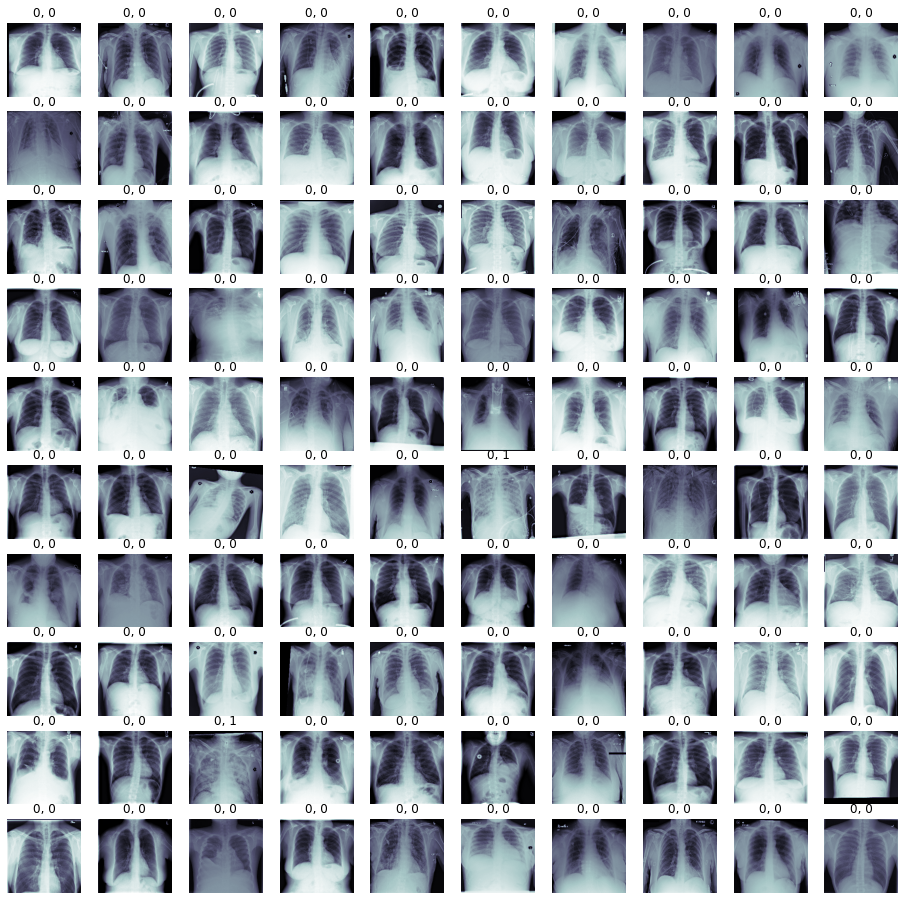

In [15]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(all_valX[0:100], all_valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_all_valY[i] > best_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_all_valY[i] > best_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [16]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)